# Convolutional Neural Network ( CNN )

<table><tr><td bgcolor=lightyellow>In deep learning, a convolutional neural network (CNN) is a class of deep neural networks, most commonly applied to analyzing visual imagery. We introduce it here with two examples.

## Example 1

<table><tr><td bgcolor=lightyellow>The first example is using CNN to identify images of digits.
<br>Data source:https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras/data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Data Preparation

<table><tr><td bgcolor=lightyellow>The images are kept as matrices, each row containing 784 pixels and label of the digit in the first column as shown below. Considering the limit of memory here, we just take part of the whole data.

In [2]:
train = pd.read_csv("http://repo.aiquanta.cloud/aiquanta/app/academic/machinelearning/introduction/appendix/asset/csv/latest/convolutional-neural-network-example-1.csv")
train = train[0:4200]
print(train.shape)

HTTPError: HTTP Error 403: Forbidden

In [ ]:
train

<table><tr><td bgcolor=lightyellow>From the training data, we take the labels as Y (result) and the rest as X (input).

In [ ]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)

In [ ]:
Y_train.value_counts()

<table><tr><td bgcolor=lightyellow>As shown above, we count the numbers of different digits, and the result turns out that they have close values.

<table><tr><td bgcolor=lightyellow>To have a view at the relationship between the vectors of pixels and the images, we take the 4th row of the training data as example, we show the image and use the label as the title, which match well.

In [ ]:
img_eg=np.array(X_train)[3].reshape(28,28)
plt.imshow(img_eg,cmap='gray')
plt.title(np.array(Y_train)[3])
plt.axis("off")
plt.show()

<table><tr><td bgcolor=lightyellow>Next, we set the value of pixels to be within the range of 0 to 1. 

In [55]:
X_train = X_train / 255.0
#test = test / 255.0

<table><tr><td bgcolor=lightyellow>Since we want the pixels of each image to be matrices and Keras (which we are gonna use to build the CNN) needs an extra dimension in the end which correspond to channels(it's 1 here because the images are gray scaled), we reshape the input.

In [56]:
X_train = X_train.values.reshape(4200,28,28,1)
#test = test.values.reshape(28000,28,28,1)


<table><tr><td bgcolor=lightyellow>The initial Y are the labels which are 0,1,2.... For identification, we convert them into vectors, and thus for example:<br> 2 becomes [0,0,1,0,0,0,0,0,0,0] <br> 0 becomes [1,0,0,0,0,0,0,0,0,0].

In [57]:
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 10)
print(Y_train[0])

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


<table><tr><td bgcolor=lightyellow>At the last step of data preparation, split the data into train and test sets(here we take only $\frac{1}{10}$ of the data as test sets).

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

### CNN Model

<table><tr><td bgcolor=lightyellow>There are different parts in CNN:
<br>1.$\underline{Convolution\ \ Layer}$: Take a small matrix as the feature(kernel, filter), which can be a n by n matrix. Successively, convolve each part(size determined by feature) of the initial matrix and the feature, and we get a feature map as a result.
<br>To avoid decreasing the size after convolution, we use $\underline{padding}$ here, normally adding 0s to the edges.
<br><br>2.$\underline{Activation\ \ Function}$: we use Relu(Rectified Linear Units) here, whose fomula is simple: $f(x)=max(0,x)$, and thus the negative values are turned into 0 while the positive values remain.
<br><br>3.$\underline{Pooling}$: Pooling can shrink a large image while retaining important information. Here, we use Max Pooling: Usually, the pooling matrix is 2 by 2 size, the maximum value in the 2\*2 size block in the input image is taken as the resulting pixel value.
<br><br>4.$\underline{Fully\ \ Connected\ \ Layers}$: In the fully connected layers below, we flatten the pooled feature maps into vectors. Every value we get in the vectors votes for the result, realized by the activation functions. Here, we also include softmax function, the formula of which is: $P=\frac{e^{x^{T}W_j}}{\sum_ke^{x^TW_k}}$. The result represents the probability of the type of the output.
<br><br>In the CNN built below, Dropout is used, where randomly selected neurons are ignored during the training.

In [59]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (28,28,1))) 
#kernel size refers to the size of the feature matrix
#filters refer to the number of output filters in the convolution
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))      #strides refer to the factor by which to downscale.
model.add(Dropout(0.25))
#fully connected
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))   #the first number in the () of Dense refers to the dimension of the output.

<table><tr><td bgcolor=lightyellow>After the construction of the strcture of CNN, we need to set the optimizer. Here we choose Adam, which is an algorithm for performing a stepwise optimization on stochastic objective functions, and the parameters are the ones mostly used in machine learning.
<br>For the loss, we use categorical_crossentropy:$$CCE = -\frac{1}{N}\sum_{i=0}^N\sum_{j=0}^Jy_{i,j}\cdot log(P_{i,j})$$

In [60]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [61]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

<table><tr><td bgcolor=lightyellow>The training process can consist of several epochs, one epoch means one forward pass and one backward pass of all the training examples and batch size means the number of training examples in one forward/backward pass.

In [67]:
epochs = 10  # for better result increase the epochs
batch_size=200

<table><tr><td bgcolor=lightyellow>Then, we fit the model with both the training set and validation set which evaluates the fit.

In [68]:
history = model.fit(X_train,Y_train, batch_size = None,epochs = epochs, validation_data = (X_val,Y_val), validation_steps=X_train.shape[0] // batch_size, steps_per_epoch=X_train.shape[0] // batch_size)

Train on 3780 samples, validate on 420 samples

Epoch 1/10
18/18 [==============================] - 115s 6s/step - loss: 0.4507 - acc: 0.8612 - val_loss: 0.3412 - val_acc: 0.9071
Epoch 2/10
18/18 [==============================] - 115s 6s/step - loss: 0.3149 - acc: 0.9027 - val_loss: 0.2783 - val_acc: 0.9214
Epoch 3/10
18/18 [==============================] - 113s 6s/step - loss: 0.2387 - acc: 0.9257 - val_loss: 0.2424 - val_acc: 0.9333
Epoch 4/10
18/18 [==============================] - 114s 6s/step - loss: 0.1917 - acc: 0.9393 - val_loss: 0.2158 - val_acc: 0.9357
Epoch 5/10
18/18 [==============================] - 113s 6s/step - loss: 0.1613 - acc: 0.9490 - val_loss: 0.1956 - val_acc: 0.9429
Epoch 6/10
18/18 [==============================] - 113s 6s/step - loss: 0.1364 - acc: 0.9554 - val_loss: 0.1877 - val_acc: 0.9452
Epoch 7/10
18/18 [==============================] - 113s 6s/step - loss: 0.1183 - acc: 0.9616 - val_loss: 0.1767 - val_acc: 0.9452
Epoch 8/10
18/18 [=================

<table><tr><td bgcolor=lightyellow>After we trained the model, plot the accuracy and loss versus epochs of both the train and validation(test) set.

Text(0.5,1,'Loss of Validation')

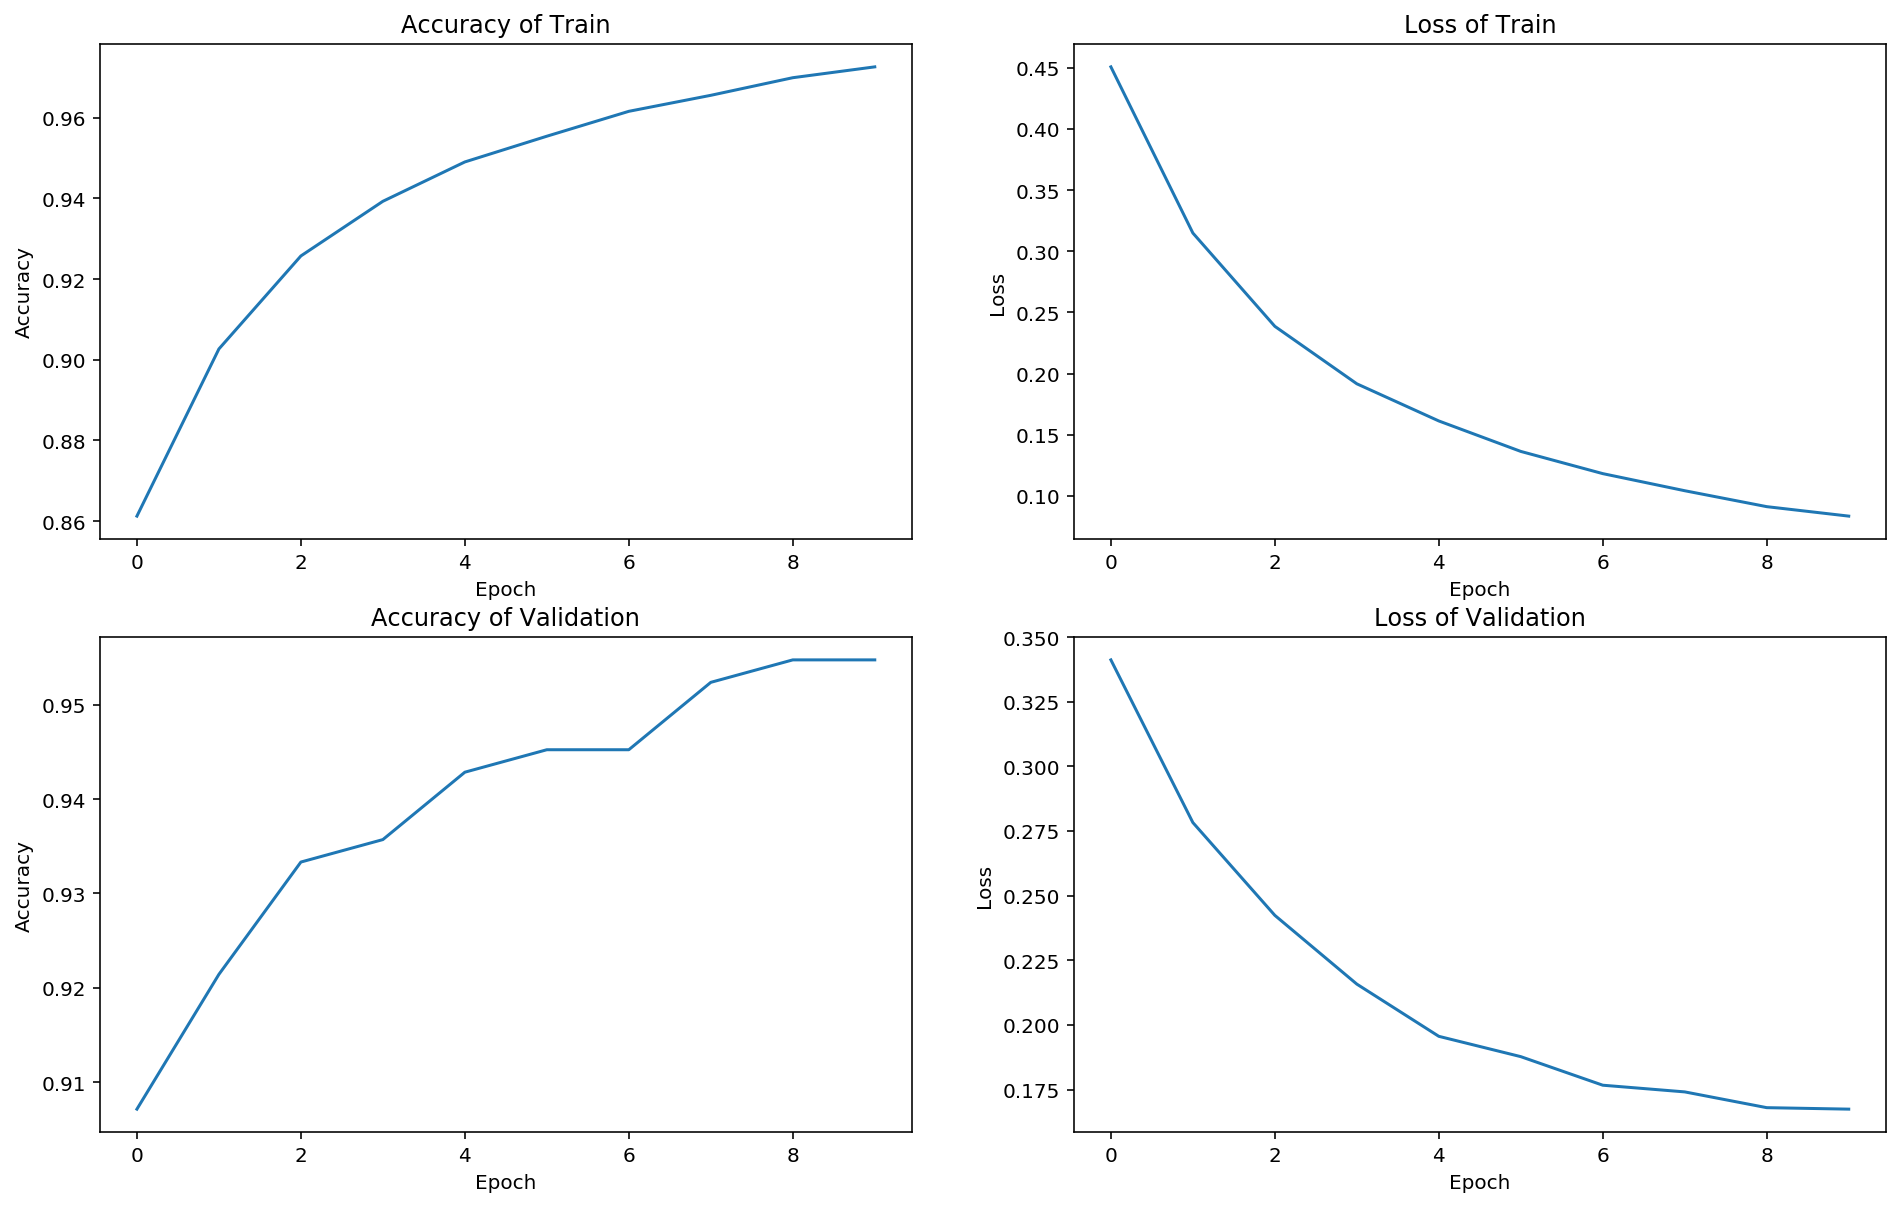

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
ax[0,0].plot(history.history['acc'])
ax[0,0].set_xlabel('Epoch')
ax[0,0].set_ylabel('Accuracy')
ax[0,0].set_title('Accuracy of Train')
ax[0,1].plot(history.history['loss'])
ax[0,1].set_xlabel('Epoch')
ax[0,1].set_ylabel('Loss')
ax[0,1].set_title('Loss of Train')
ax[1,0].plot(history.history['val_acc'])
ax[1,0].set_xlabel('Epoch')
ax[1,0].set_ylabel('Accuracy')
ax[1,0].set_title('Accuracy of Validation')
ax[1,1].plot(history.history['val_loss'])
ax[1,1].set_xlabel('Epoch')
ax[1,1].set_ylabel('Loss')
ax[1,1].set_title('Loss of Validation')

<table><tr><td bgcolor=lightyellow>The accuracy is acceptable to some extent.
<br>For more direct view of the fit, plot the confusion matrix of the test set.

### Model Evaluation

In [92]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) #return the max of the axis
Y_true = np.argmax(Y_val,axis = 1)

In [93]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

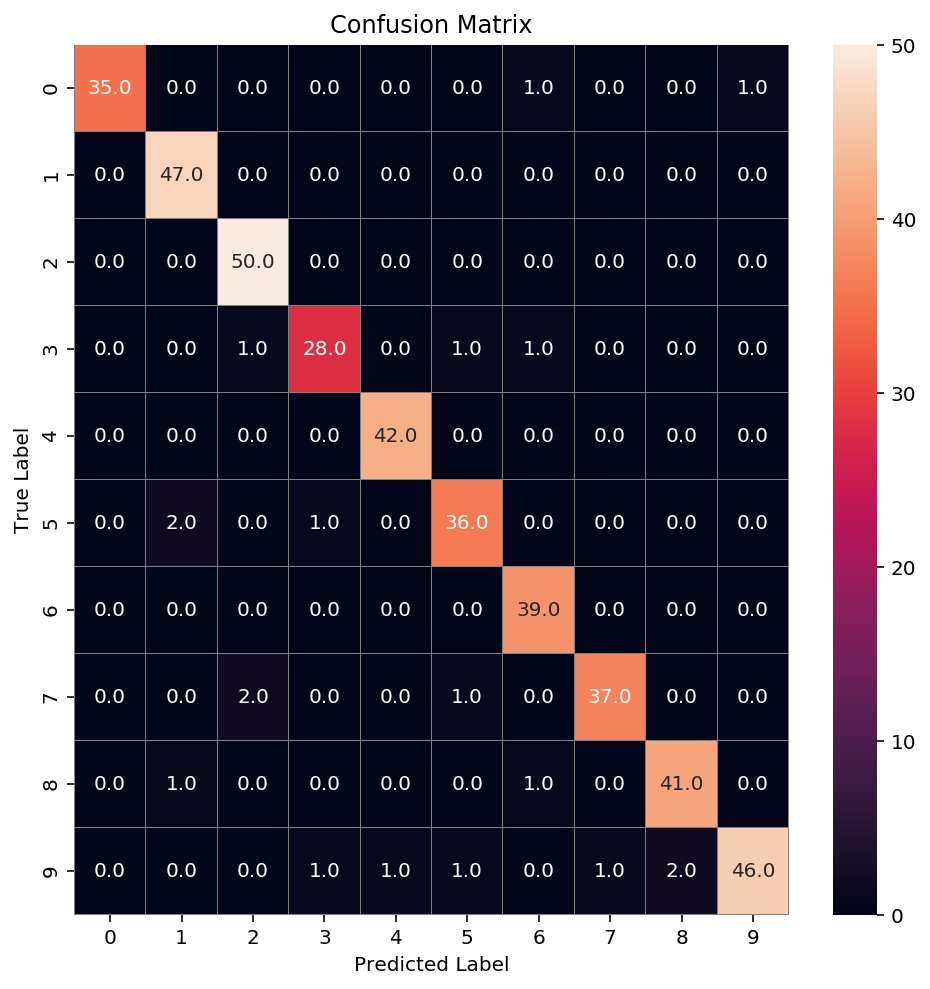

In [94]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)#fmt refers to type of the data
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

<table><tr><td bgcolor=lightyellow>Through the confusion matrix, we can see exactly how well the test set are predicted

## Example 2

<table><tr><td bgcolor=lightyellow>Inspired by the paper Super-resolving the Ising model with convolutional neural networks(https://arxiv.org/abs/1810.02372), we try to use CNN here to restore the decimated configurations of the Ising model back to the initial size with high accuracy.

In [21]:
import numpy as np
import pandas as pd
import copy
import csv

### Data Preparation

<table><tr><td bgcolor=lightyellow>We got initial data from Monte Carlo, and they are 200 configurations of 16 by 16 matrices for each T of totally 61 different Ts.

In [22]:
csvFile = open("data/data_L=16_Ts(200).csv", "r")
reader = csv.reader(csvFile)
rows= [row for row in reader]
cdata=np.array(rows)
data_allT=np.zeros((61,np.array(rows[0]).size))
for i in range(0,61):
    data_allT[i]=cdata[2*i]

In [23]:
data_separate=data_allT.reshape(61,int(data_allT[0].size/(16*16)),16*16)

<table><tr><td bgcolor=lightyellow>Our purpose is to get the initial configurations from the decimated ones, so we set the initial 16*16 matrices as y, and since we'll use sigmoid functions later, we turn the spin value of -1 into 0 while the spin value of 1 remains.

In [24]:
Y_train=copy.deepcopy(data_separate.reshape(-1,256))
for i in range(0,len(Y_train)):
    for j in range(0,256):
        if Y_train[i,j]==-1:
            Y_train[i,j]=0
        else:
            Y_train[i,j]=1

<table><tr><td bgcolor=lightyellow>To do the decimation, the rule is that each 16*16 matrix can be divided into 8*8 blocks, and each block then be replaced by a single value. If the sum of a block >=0, then the value is 1, or else it's -1.

In [25]:
data_dec=np.zeros((int(data_allT.size/(16*16)),64))
data_T=copy.deepcopy(data_separate.reshape(-1,256))
for i in range(0,int(data_allT.size/(16*16))):
    ini=data_T[i]
    for ii in range(0,8):
        for iii in range(0,8):
            x=2*ii+32*iii
            sum=ini[x]+ini[x+1]+ini[x+16]+ini[x+17]
            if sum >= 0:
                data_dec[i,ii+iii*8]=1
            else:
                data_dec[i,ii+iii*8]=-1

<table><tr><td bgcolor=lightyellow>To fit the model, add an additional dimension to the input.

In [26]:
X_train=data_dec.reshape(-1,8,8,1)

### CNN Model

<table><tr><td bgcolor=lightyellow>As we did before, separate the data into train set and validation set.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

<table><tr><td bgcolor=lightyellow>Unlike the periodic boundary used in the paper to avoid size decreasing, we just use the normal padding and choose linear activation function this time in the convolution layer. In the final layer, use sigmoid function, since the values we want in the configuration are binary.

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D,Activation
from keras.optimizers import RMSprop,Adam
from keras.callbacks import ReduceLROnPlateau


model2 = Sequential()
model2.add(Conv2D(filters = 6, kernel_size = (5,5),padding = 'Same',activation ='linear'))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters = 12, kernel_size = (3,3),padding = 'Same',activation ='linear'))
#fully connected
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(256, activation = "sigmoid"))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


KeyboardInterrupt: 

<table><tr><td bgcolor=lightyellow>As we used sigmoid function at last, choose binary_crossentropy as the loss function.

In [29]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model2.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [30]:
epochs = 10  # for better result increase the epochs
batch_size = 600


<table><tr><td bgcolor=lightyellow>With model constructed and parameters set, fit the model.

In [31]:
history = model2.fit(X_train,Y_train, batch_size = None,epochs = epochs, validation_data = (X_val,Y_val), validation_steps=X_train.shape[0] // batch_size, steps_per_epoch=X_train.shape[0] // batch_size)

Train on 10980 samples, validate on 1220 samples

Epoch 1/10
18/18 [==============================] - 72s 4s/step - loss: 0.5035 - acc: 0.7351 - val_loss: 0.3683 - val_acc: 0.8147
Epoch 2/10
18/18 [==============================] - 72s 4s/step - loss: 0.3342 - acc: 0.8560 - val_loss: 0.2640 - val_acc: 0.9169
Epoch 3/10
18/18 [==============================] - 72s 4s/step - loss: 0.2412 - acc: 0.9211 - val_loss: 0.1824 - val_acc: 0.9557
Epoch 4/10
18/18 [==============================] - 72s 4s/step - loss: 0.1685 - acc: 0.9551 - val_loss: 0.1209 - val_acc: 0.9759
Epoch 5/10
18/18 [==============================] - 72s 4s/step - loss: 0.1167 - acc: 0.9732 - val_loss: 0.0795 - val_acc: 0.9845
Epoch 6/10
18/18 [==============================] - 72s 4s/step - loss: 0.0833 - acc: 0.9825 - val_loss: 0.0545 - val_acc: 0.9890
Epoch 7/10
18/18 [==============================] - 71s 4s/step - loss: 0.0626 - acc: 0.9871 - val_loss: 0.0395 - val_acc: 0.9915
Epoch 8/10
18/18 [======================

In [32]:
print('The final accuracy of the train set is :',history.history['acc'][-1])
print('The final accuracy of the validation set is :',history.history['val_acc'][-1])

The final accuracy of the train set is : 0.9929442207018534

The final accuracy of the validation set is : 0.9962282180786133


<table><tr><td bgcolor=lightyellow>From the accuracy, we can tell that the fit is accaptable for 16 by 16 matrices.

### Model Evaluation

<table><tr><td bgcolor=lightyellow>First, get the predictions of the decimated matrices.

In [33]:
pre=model2.predict(data_dec.reshape(-1,8,8,1))

<table><tr><td bgcolor=lightyellow>Remember that we previously turned the the spin into 0 and 1, so we need to change them back into -1 and 1 by choosing the values >=0.5 as 1 and others as -1.

In [34]:
pre_re=copy.deepcopy(pre)
for i in range(0,len(pre_re)):
    for j in range(0,256):
        if pre_re[i,j]>=0.5:
            pre_re[i,j]=1
        else:
            pre_re[i,j]=-1

<table><tr><td bgcolor=lightyellow>Then we try to get the average magnetization of the 200 samples of each T, and plot the predicted results and initial ones together to evaluate our fit.

In [35]:
M_real=[]
M_predict=[]
for i in range(0,61):
    M1=0
    M2=0
    forT1=data_separate.reshape(-1,256)[i*200:i*200+200]
    forT2=pre_re[i*200:i*200+200]
    for j in range(0,200):
        M1=M1+abs(np.sum(forT1[j])/256)
        M2=M2+abs(np.sum(forT2[j])/256)
    M_real.append(M1/200)
    M_predict.append(M2/200)

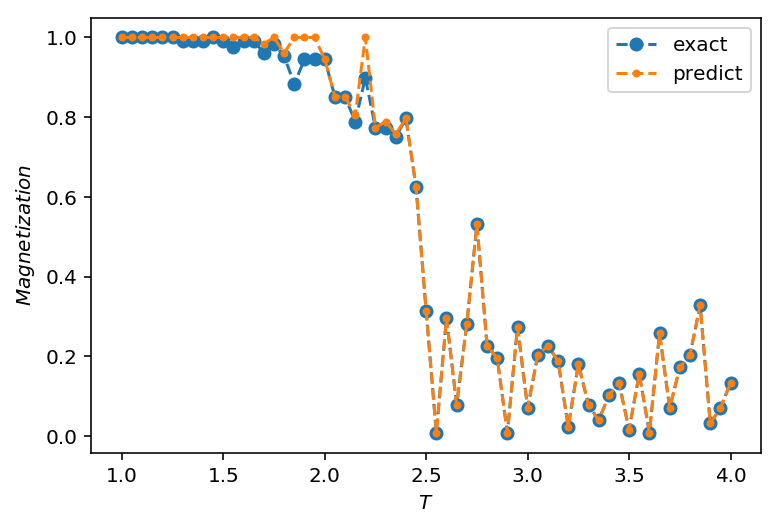

In [37]:
import matplotlib.pyplot as plt

Temp=np.arange(1,4.05,0.05)
plt.plot(Temp,M_real,label='exact',ls='--',marker='o')
plt.plot(Temp,M_predict,label='predict',ls='--',marker='.')
plt.xlabel(r"$T$")
plt.ylabel(r"$Magnetization$")
plt.legend()

<table><tr><td bgcolor=lightyellow> From the figure, the model is well fitted. The initial sample base are small and so are not that satisfactory.